
## Data Science Teaching Agent - Graph Approach

This notebook presents a holistic educational experience where each concept is not only explained in text but accompanied by illustrative images and practical code examples.

a Keras-based agent will leverage Gemma to traverse a graph of tasks designed to enrich the educational journey for data scientists. While the focus is on Gemma LLM model, stable diffusion is used to validate the ability of the model to describe concept related images as a cover for tutorial posts.

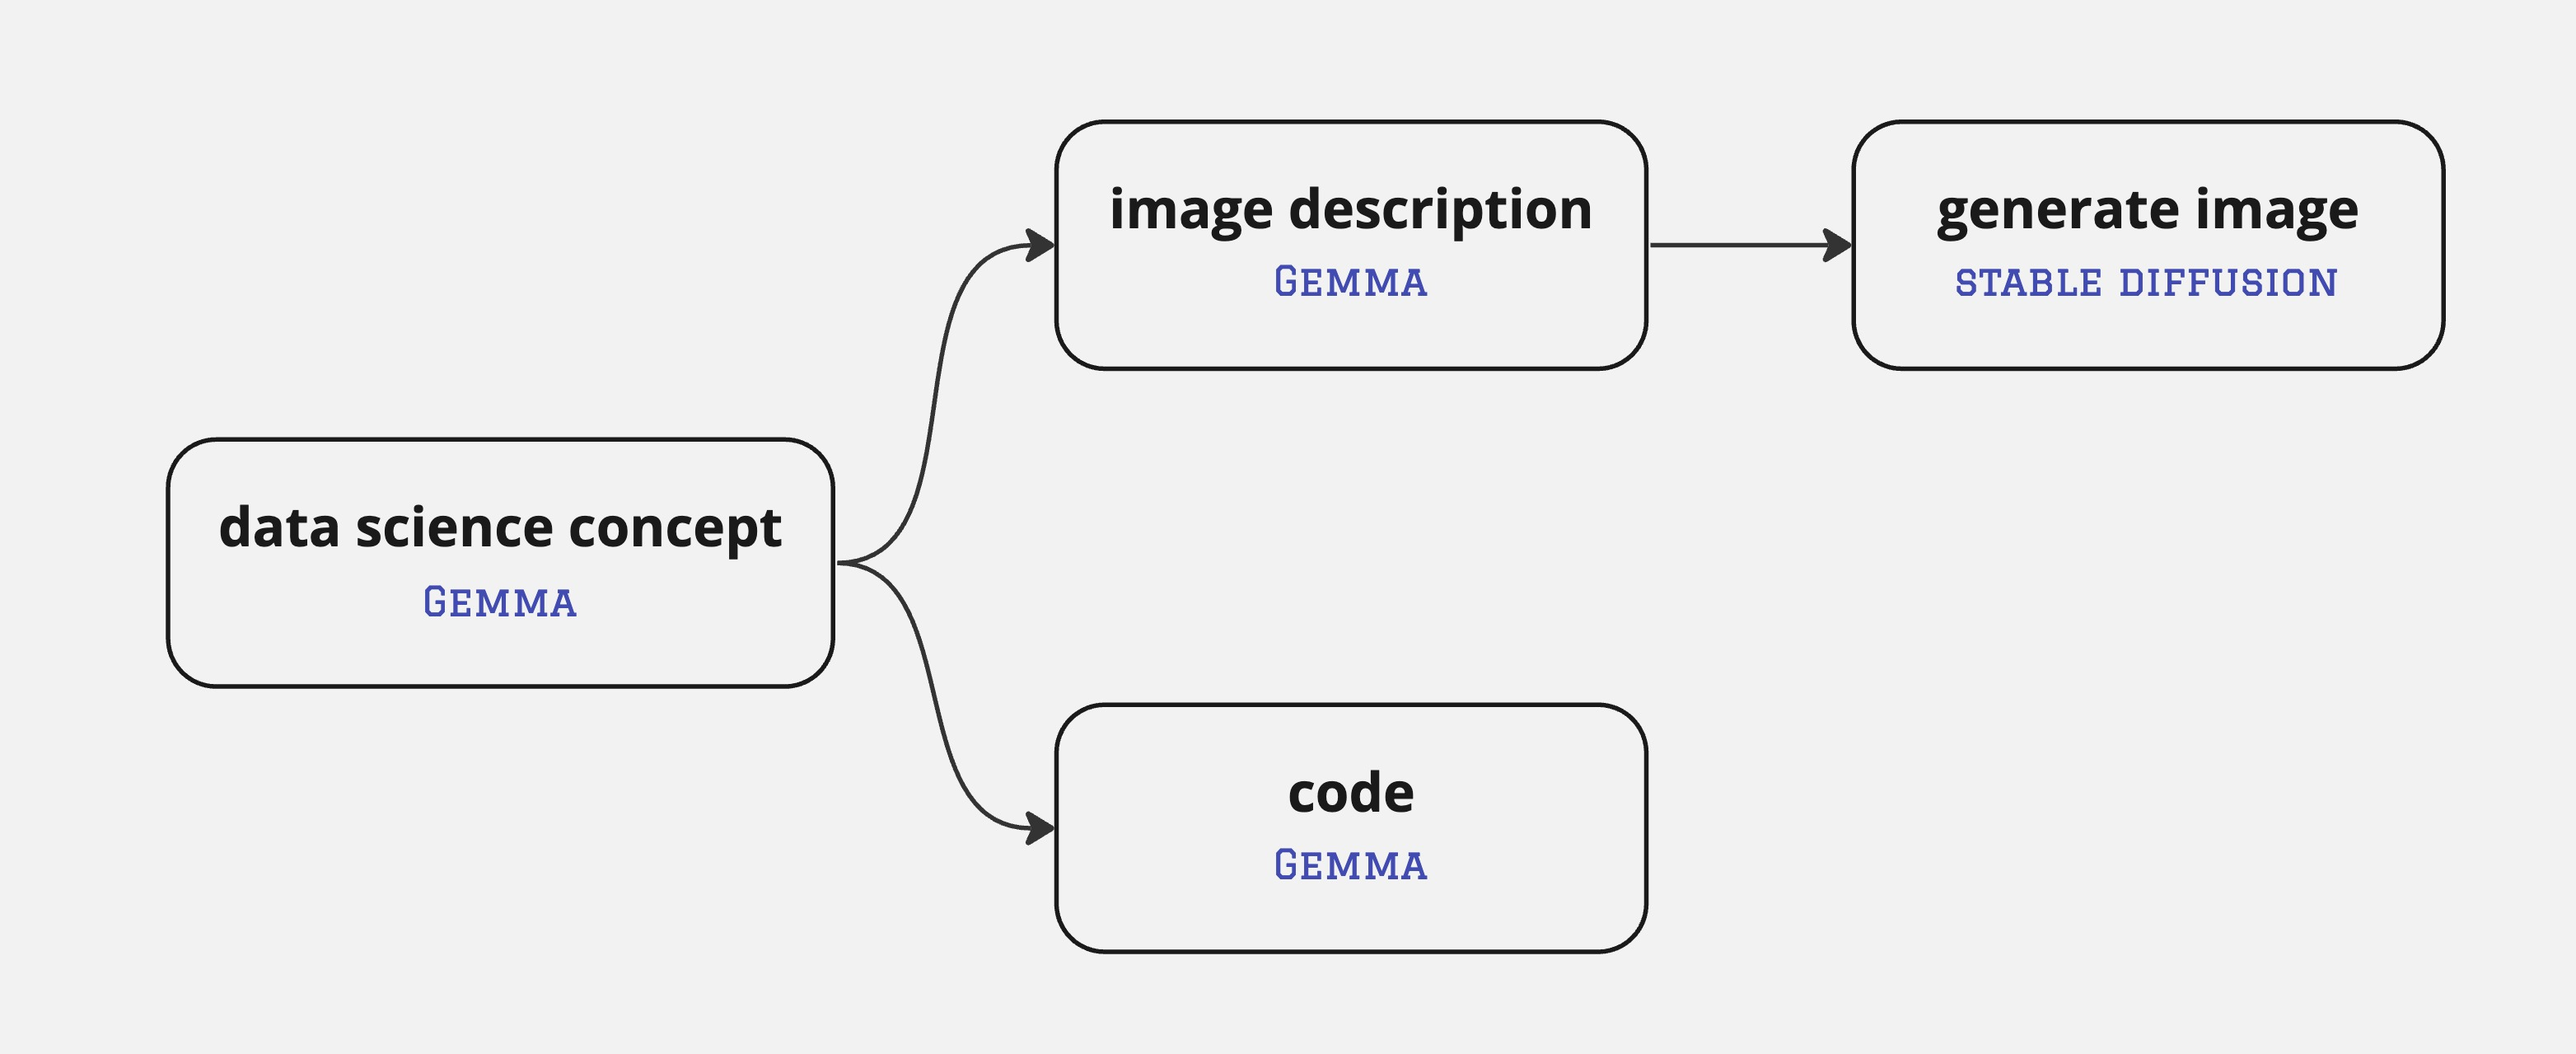
*(Image by author)*

After creating the interactive data science concept materials, we'll explore techniques to improve Gemma's output, such as few-shot learning and fine-tuning.

This approach targets the second competition task:

1. Answer common questions about the Kaggle platform. 
2. **Explain or teach basic data science concepts**.
3. Summarize Kaggle Solution write ups.
4. Explain or teach concepts from Kaggle Solution write ups.
5. Answer common questions about the Python programming language.

## Setup

In [ ]:
!pip install keras-nlp
!pip install --upgrade keras>=3
!pip install --upgrade intelli

## Gemma as an Agent

Gemma is a family of lightweight open-source language models designed to be accessible on medium size devices like laptops and desktops. The models achieved strong performance on key benchmarks for their size. Keras will be used to load the models locally and intelli framework to navigate users tasks as a graph.

The models architecture is a decoder only transformer and released with two main sizes:

| Parameter | 2B Parameters | 7B Parameters |
|---|---|---|
| d model | 2048 | 3072 |
| Layers | 18 | 28 |
| Feedforward hidden dims | 32,768 | 49,152 |
| Num heads | 8 | 16 |
| Num KV heads | 1 | 16 |
| Head size | 256 | 256 |
| Vocab size | 256,128 | 256,128 |
| context tokens | 8192 | 8192 |
|*(The table from [gemma technical report](https://goo.gle/GemmaReport))*|

### Imports

In [ ]:
import os
import base64
import unittest
from intelli.flow import KerasAgent, Agent, TextTaskInput, Task
import base64
# set keras backend
os.environ["KERAS_BACKEND"] = "jax"

In [ ]:
from IPython.display import Markdown
from IPython.display import Image
import PIL

## 1- Create Agents

We require only two agents to accomplish our task: 
- One powered by Gemma for text generation tasks.
- Second leveraging Stable Diffusion for image generation.

**Keras agent**

The gemma 2B parameter will be loaded within the notebook memory. We will use the instruct version as it adhere more to the user instructions.

In [ ]:
# gemma agent
gemma_model_params = {
            "model": "gemma_instruct_2b_en",
            "max_length": 200
        }

# the agent uses GemmaCausalLM to load the model
gemma_agent = KerasAgent(agent_type="text",
                         provider="gemma",
                         model_params=gemma_model_params)

The KerasAgent uses below code to load the Gemma model:
```python
import keras_nlp

if "gemma" in model_name:
    print("start gemma model")
    return keras_nlp.models.GemmaCausalLM.from_preset(model_name)
```

**Stable diffusion agent**

We will use the Stable Diffusion model behind API from the stability.ai. To generate the data science concept's images click on **Add-ons**, then choose secrets to add your stability key. If the key is not available, the final output will include the text model output without the image.

In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()

# load the stability key from Add-ons/secrets
STABILITY_API_KEY = user_secrets.get_secret("STABILITY_API_KEY")

In [ ]:
# stable diffusion agent
artist_agent = Agent(agent_type="image", 
                     provider="stability", 
                     mission="generate logo with colorful style", 
                     model_params={"key": STABILITY_API_KEY})

## 2- Create Tasks

Four tasks will be used to generate interactive data science materials:
* **Task1**: generate an answer about a data science concept.
* **Task2**: will write an image description to use for the image model.
* **Task3**: generate base64 image.
* **Task4**: write a python skeleton code related to the concept.

In [ ]:
# try to update with any DS concept of your choice
ds_concept = "Neural networks"

In [ ]:
# generate answer about data science concept.
task1 = Task(
            TextTaskInput("Describe the data science concept: {0}.".format(ds_concept)), 
            agent=gemma_agent, log=False)

# write an image description.
task2 = Task(
            TextTaskInput("Generate image description related to the data science concept in context."), 
            agent=gemma_agent, model_params={"max_length": 300}, log=False)


# optional - generate base64 image.
task3 = Task(
            TextTaskInput("Generate an image to describe the data science concepts from the desc."), 
            agent=artist_agent, log=False)

# write a python code.
task4 = Task(
            TextTaskInput("Write a high level python code to show how to implement {0}.".format(ds_concept)), 
            agent=gemma_agent, model_params={"max_length": 800}, log=False)

## 3- Graph Based Flow
We will use graph-based orchestration to funnel user inputs across different stages of our workflow, the intelli framework will handle passing the output of previous tasks to the next step.

In [ ]:
from intelli.flow.flow import Flow

flow = Flow(
    tasks={
        "ds_concept": task1,
        "image_desc": task2,
        "generate_image": task3,
        "coder": task4,
    },
    map_paths={
        "ds_concept": ["image_desc", "coder"],
        "image_desc": ["generate_image"]
    },
    log=True
)

Generate a graph that describe our work flow and assigned agents

In [ ]:
flow.generate_graph_img()
PIL.Image.open("graph_img.png")

**Start the flow** 

This step will generate the output from all tasks.

In [ ]:
output = await flow.start()

## Validate the Generated Output

**The data science concept output**

In [ ]:
Markdown(output['ds_concept']['output'])

**Display the concept cover image**

The image generation is an optional step as the notebook focuses on Gemma model. The image might not be generated in the cases where you don't provide the stability key.

In [ ]:
if 'generate_image' in output: 
    image_base64 = output['generate_image']['output']
else:
    image_base64 = ''
    print("the image not generated")

In [ ]:
# display the image
Image(data=base64.b64decode(image_base64))

**The output from python coder task**

In [ ]:
Markdown(output['coder']['output'])

You can look to the generated text, cover image and code as a building block for a comprehensive teaching tutorial; we will discuss in the next section techniques to tune the image description and the code writing.

## Few-Shot Learners

Transformer architecture provides the ability to adapt to new tasks or generate responses in specific styles with only a small number of examples. This approach is useful to swiftly tailor a model to specific requirements without expensive tuning.

**Current description**

Let's validate the generated image description and try to improve it to be relevant to education using a few shot examples.

In [ ]:
print(output['image_desc']['output'])

#### Improve the description

The generated description talks about neural networks in general instead of describing a scene, we will use the below prompt template to guide the Gemma model on how to general more relevant image to the education and assess the impact on the generated image.

In [ ]:
prompt_template = f"""
Generate one image description related to the user concept for education materials.

User: supervised learning

Desc: A cartoon style diagram showing a flow of data points, each tagged with a label, entering a stylized representation of a computer algorithm. The algorithm is depicted sorting these data points based on their labels, with a clear demarcation between different categories.

User: regression analysis

Desc: A vibrant, cartoon style illustration featuring a scatter plot with various data points strewn across, and a bold, dashed line smoothly curving through them, representing the best fit line. Floating above, smaller graphics hint at the concept of minimizing the distance between the line and the points, symbolizing the regression analysis process aimed at predicting values.

User: {ds_concept}

Desc: 
"""

#### Call the task

We will call the task directly for simplicity and check if the new prompt improves the results.

In [ ]:
task2 = Task(
            TextTaskInput(prompt_template), 
            agent=gemma_agent, 
            model_params={"max_length": 200}, 
            log=False)

In [ ]:
task2.execute()

In [ ]:
Markdown(task2.output)

#### Observations on the few-shot learning

The generated descriptions tailored the output to describe scenes in a specific style, as showcased in the examples. We implemented a two-shot example, there is a potential for further customisation by feeding more examples. 

Few shots provide a quick win to tune the model response. For complex cases where a few shots do not provide value, you can try fine-tuning, which requires more resources and training data.

## Fine-Tuning Gemma

You can further adjust Gemma for data science teaching using fine-tuning. This involves training Gemma on your codebase to adjust its code generation to align with your preferred libraries, coding style, and educational curriculum.

We will use a Kaggle dataset to simulate tuning Gemma on a specific course or company coding repo to write the concept coding in a specific style. While this might not be the optimal dataset for the data science concept, it is only a simulation to show how to adjust the model for specific coding repos.

#### Load and view the data

In [ ]:
import gc
# force memory clean before the extensive tuning task
gc.collect()

In [ ]:
import pandas as pd

# load the data 
data = pd.read_csv("/kaggle/input/python-code-instruction-dataset/train.csv")

In [ ]:
print("number of row: {} and cols: {}".format(data.shape[0], data.shape[1]))

In [ ]:
# view the data
data.head(3)

In [ ]:
# sample the code to accelerate the tuning
data.dropna(inplace=True)
data = data.sample(frac=0.1)
print("the sample number of row: {} and cols: {}".format(data.shape[0], data.shape[1]))

#### Format the data

We will format the data to match the gemma fine-tuning template, which requires including the request and response in one pass.

In [ ]:
def get_tuned_pass(problem, code, code_format=False):
    if code_format:
        return "User: {} Code: \n ```python\n{}\n```".format(problem.strip(), code)
    else:
        return "User: {} Code: {}".format(problem.strip(), code)

In [ ]:
# prepare the tuning data
formatted_data = [get_tuned_pass(problem, code, code_format=True) for problem, code in zip(data['instruction'], data['output'])]
print('size of training data: ', len(formatted_data))

In [ ]:
# example of training data
Markdown(formatted_data[0])

#### Start fine tuning

This fine-tuning process tailors the model's output to align with your dataset.
**In the optimal scenario, we'd leverage two models. The first model specialises in text generation, and the second model is fine-tuned to address code generation based on the institution's repos/standards.**

For this tutorial, we'll simplify due to the limited memory and fine-tune the same gemma_agent on the coding repo. However, it is important to remember once a model is tuned on a specific task, this will impact the ability to generalise. In such cases where the same model is used for multiple tasks, you can use a few shots or retrieval generation to adjust the responses.

Let's start the fine-tuning.

The intelli framework provides a one-call function to fine-tune Keras models, you have to prepare the tuning parameters and pass it to `fine_tune_model_with_lora`. We use LoRA to reduce the training time, as it focuses on a smaller set of trainable parameters. 

Lora leverages low-rank updates during fine-tuning to expedite the training process. Instead of directly modifying the massive weight parameters of the LLM, it introduces a smaller set of matrices that capture the essential adjustments for the specific task.

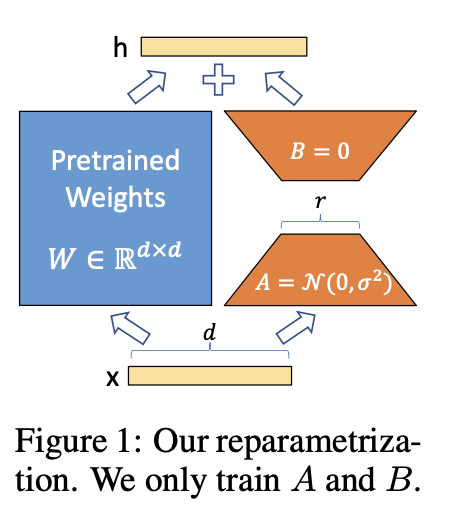

(*Image from LORA paper*)

We will use the following configurations to fine tune the model:
* `lora_rank` (integer): Controls the level of compression using Low-Rank Adaptation (LORA). Lower values lead to smaller model size but potentially less accuracy.
* `sequence_length` (integer): The maximum length of sequences considered during training. Sequences exceeding this length will be truncated.
* `learning_rate` (float): Controls how much the model updates its weights during training. A lower value leads to slower but potentially more stable learning.
* `weight_decay` (float): A regularization technique that penalizes large weight values to prevent overfitting.
* `epochs` (integer): The number of trianing iterations, each epoch pass through all the training data.
* `batch_size` (integer): The number of data processed together in one training step. 

Due to memory constraints we tune using 180 sequences only.

In [ ]:
fine_tuning_config = {
    "dataset": formatted_data,
    "lora_rank": 4,
    "sequence_length": 180,
    "learning_rate": 5e-5,
    "weight_decay": 0.01,
    "epochs": 1,
    "batch_size": 1
}
# one line call for fine tuning
gemma_agent.fine_tune_model_with_lora(fine_tuning_config, enable_lora=True)

You can explore the wrapped code behind `fine_tune_model_with_lora` function [here](https://github.com/intelligentnode/Intelli/blob/main/intelli/flow/agents/kagent.py#L94).

#### Create a task to try the tuned agent

The 180 `sequence_length` is short for complete concept implementation. We will test with basic code that fit within this window size. With appropriate hardware, you can experiment increasing the sequence length.

In [ ]:
# we should use the input format that used for the fine tuning
coding_prompt = get_tuned_pass(problem="write keras simple one layer neural network", code="")
print(coding_prompt)

In [ ]:
coder_task = Task(
            TextTaskInput(coding_prompt), 
            agent=gemma_agent, model_params={"max_length": 180}, log=False)

#### Call the task

We will call the task directly (not part of the graph flow) for simplicity and check if the new prompt improve the results.

In [ ]:
coder_task.execute()

In [ ]:
print(coder_task.output)

## Conclusion


We explored how to leverage Gemma as an agent to generate interactive data science teaching materials. This includes how to chain multiple agents together in a graph-based structure, allowing managing dependencies and passing the input through multiple tasks.

Then we improved one of the tasks "the image description" using few-shot learning. This allows you to quickly tailor the model's response style with just a handful of examples. Finally, we introduced fine-tuning to further customise Gemma for your specific tasks. Remember that fine-tuning a model on a specific task can impact its ability to generalise. If the same model is used for multiple tasks, consider using few-shot learning or response augmentation.


By combining these techniques, you can build advanced systems.